### AI61002 Project . Covid 19 Assignment
# Bengali Digit Recognition in the Wild
#### Submitted By
# SHUBHRAJYOTI SARKAR
# 15PH20028

Many concepts and codes have been used from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Discussion with batchmates and friends for better understanding as well.

Questions
Q: how you have split the dataset into train, test, validation?  
A: Test dataset was already given, therefore I have splitted the other data into train and validation only.


Q: Chave you taken any methods to compensate for class imbalance?  
A: Yes I have used the oversampling mothod.

Q: any conditions of hot restart during training?  
A: yes I have incorporated this.

Q: present the training/validation loss curves and indicate how you have chosen the stopping criteria?  
A: when validation loss starts increasing, It also has bn used as the stopping criteria

In [1]:
# Basic libraries
import os, sys, math, time, copy, shutil, random
from collections import Counter

# Image libraries
import seaborn as sns
from PIL import Image

# Dataset libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit learn libraries
from sklearn.utils import resample
from skimage import io, transform

# Torch libraries
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing data

In [0]:
PATH = "data/dataset/"
df = pd.read_csv("data/dataset/Covid19action-radiology-CXR_v1.1/Train_Combined.csv")
df

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,CASE58_XRAY_1.jpeg,Source-2,1,0,0,1
1,case2_xray_1.jpeg,Source-2,1,0,0,1
2,case2_xray_2.jpeg,Source-2,1,0,0,1
3,case8_xray_1.jpeg,Source-2,1,0,0,1
4,case8_xray_2.jpeg,Source-2,1,0,0,1
...,...,...,...,...,...,...
228933,aspiration-pneumonia-5-day27.jpg,Source-5,4,0,1,0
228934,pneumocystis-jirovecii-pneumonia-3-1.jpg,Source-5,4,0,1,0
228935,pneumocystis-jirovecii-pneumonia-3-2.jpg,Source-5,4,0,1,0
228936,pneumocystis-jirovecii-pneumonia-3-3.jpg,Source-5,4,0,1,0


In [0]:
df["Data Source"].value_counts()

Source-3    223414
Source-4      5232
Source-5       128
Source-1       109
Source-2        54
Source-7         1
Name: Data Source, dtype: int64

### Function to get image from source directory with `img_name` name and plot if `plot = True`

In [0]:
def getImage(source, img_name, plot=False):
    path = None
    if source == 1:
        path = PATH + "Covid19action-radiology-CXR_v1.1/images/Source1/"
        
    elif source == 2:
        path = PATH + "Covid19action-radiology-CXR_v1.1/images/Source2/"
        
    elif source == 3:
        # have to modify image name for this case
        # splitting image name accordingly
        z = img_name.split("__")
        img_name = z[-1]
        z[0] = z[0].split("/")[1] # Remove train_reshape
        z = z[:-1] # remove last 2 
        path = PATH + '/'.join([x for x in z]) + '/'
    elif source == 4:
        path = PATH + "rsna-pneumonia-detection-challenge/stage_2_test_images/"
    
    elif source == 5:
        path = PATH + "covid-chestxray-dataset-master/images/"
        
    elif source == 6:
        path = PATH + "Figure1-COVID-chestxray-dataset-master/images/"
    elif source == 7:
        path = PATH + "Covid19action-radiology-CXR_v1.1/images/Source7/"
    # for some images in testing file type is missing
    try:
        img = Image.open(path + img_name)
    except:
        try:
            img = Image.open(path+img_name + ".jpg")
        except:
            img = Image.open(path+img_name + ".png")
    if plot: 
        plt.imshow(img)
        plt.show()
    return img
        

### Visualizing images from some source

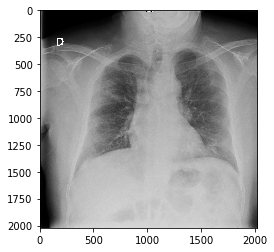

In [0]:
tmp = getImage(1, "EUNQ4TDXkAAxvth.jfif", plot=True)

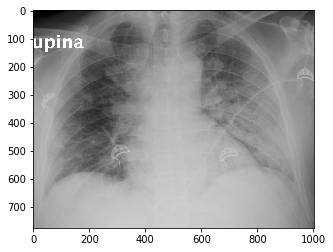

In [0]:
tmp = getImage(2, "CASE58_XRAY_1.jpeg", plot=True)

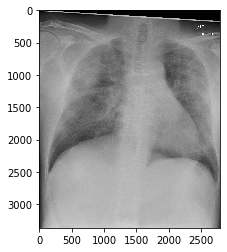

In [0]:
tmp = getImage(5, "covid-19-pneumonia-15-PA.jpg", plot=True)

In [0]:
df["Other Pneumonia"] += 1
df["Non-Pneumonia"] += 1
# df = df[df["Data Source"] != "Source-4"]
# currently source 4 doesn't work
df = df[df["Data Source"] != "Source-4"]

## Data classification visualization and making histogram

### Function to plot frequency histogram for a given set of xray results

In [0]:
def plot_freq_chart(freq):
    sns.barplot(freq.index, freq.values)
    plt.title('Class frequency')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('city', fontsize=1)
    plt.show()


### Plot frequency graph for `Non - Pneumonia` class

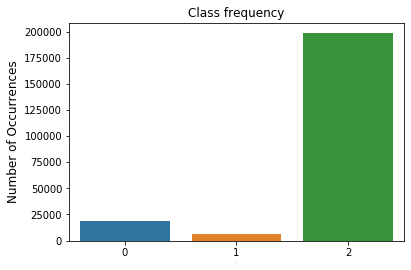

In [0]:
tmp = df["Non-Pneumonia"].value_counts()
plot_freq_chart(tmp)

### Plot frequency graph for `Other Pneumonia` class

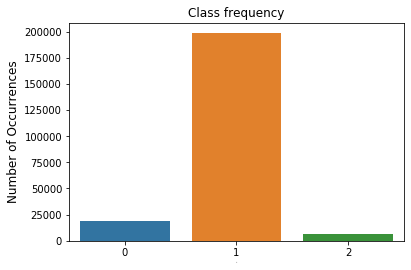

In [0]:
tmp = df["Other Pneumonia"].value_counts()
plot_freq_chart(tmp)

### Plot frequency graph for `COVID-19` class

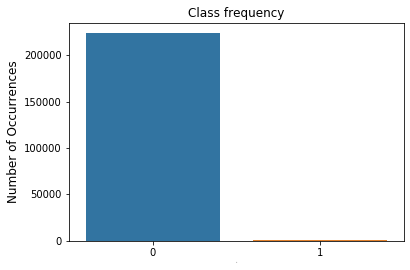

In [0]:
tmp = df["COVID-19"].value_counts()
plot_freq_chart(tmp)

## Train - Validation Split

`# Train Data Points = 0.8 * Total Data Points`

`# Validation Data Points = 0.2 * Total Data Points`

In [0]:
train_size = int(0.8 * len (df))
valid_size = len (df) - train_size
train, validate = np.split(df.sample(frac=1), [train_size])

## CovidDataset class to load the given dataset

In [0]:
class CovidDataset(Dataset):
    
    def __init__(self, df, is_test, col_no, transform=None):
        self.data = df
        self.transform = transform
        self.test = is_test
        self.col_no = col_no
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = self.data.iloc[index, 0]
        source = int(self.data.iloc[index, 1].split("-")[-1])
        image = mod(source, img_name)
        label =self.data.iloc[index][3:][self.col_no]
        
        if self.transform is not None:
            # converting image to black and white
#             image = image.convert('1')
            #converting to rgb
            image = image.convert('RGB')
            # applying transforms
            image = self.transform(image)
        
        # for train loader it returns label and image both but for test loader returns only image 
        if self.test:
            return image
        else:
            return image, label

### Visualizing data in form of table (panda's default form)

In [0]:
df

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,CASE58_XRAY_1.jpeg,Source-2,1,1,1,1
1,case2_xray_1.jpeg,Source-2,1,1,1,1
2,case2_xray_2.jpeg,Source-2,1,1,1,1
3,case8_xray_1.jpeg,Source-2,1,1,1,1
4,case8_xray_2.jpeg,Source-2,1,1,1,1
...,...,...,...,...,...,...
228933,aspiration-pneumonia-5-day27.jpg,Source-5,4,1,2,0
228934,pneumocystis-jirovecii-pneumonia-3-1.jpg,Source-5,4,1,2,0
228935,pneumocystis-jirovecii-pneumonia-3-2.jpg,Source-5,4,1,2,0
228936,pneumocystis-jirovecii-pneumonia-3-3.jpg,Source-5,4,1,2,0


In [0]:
# train = train[:10]
# validate = validate[:10]

### Transformers for data augmentation and data transformation

In [0]:
# apply_transform = transforms.Compose([
#     transforms.Resize((32, 32)), 
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# BatchSize = 512

# train_ = CovidDataset(train, False, 0, transform=apply_transform)
# trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
#                                           shuffle=True, num_workers=0) # Creating dataloader

# validate_ = CovidDataset(validate, False, 0, transform=apply_transform)
# validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
#                                           shuffle=False, num_workers=0)

## Dataloaders to load data from dataset and feed it into Deep Learning model ( Data is taken from training loader while training and from validloader while validating )

In [0]:
# dataloaders = {
#     'train': trainLoader,
#     'val': validateLoader
# }

# dataset_sizes = {
#     'train': len(train),
#     'val': len(validate)
# }

## Function to train model

It accepts some parameters:
1. dataloaders : train and valid data loaders as a dictionary
2. dataset_sizes : tuple or list of integers with size = 2 (size of train dataset, size of the validation dataset)
3. model : Computer Vision model to train
4. criterion : Criterion to update model parameters [ Loss ]
5. optimizer : Optimizer to use while updating the model parameters 
6. Scheduler : Scheduler to change model hyperparameters
7. num_epochs : Number of epochs

In [0]:
def train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = True
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print(dataset_sizes)
    best_validation_loss = 1e9 # initializing with very high error

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                # save latest for hot restart
                states = {
                    'epoch': num_epochs,
                    'state_dict': model_ft.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                torch.save(states, "./Latest_{col}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                states = {
                    'epoch': num_epochs,
                    'state_dict': model_ft.state_dict(),
                    'optimizer': optimizer_ft.state_dict(),
                    'lr_scheduler': exp_lr_scheduler.state_dict()
                }
                torch.save(states, f"./{col}_{BatchSize}_SGD_{lr}_{epoch}")
                
            # stopping criteria
            curr_validation_loss = 0.0
            for i, data in enumerate(dataloaders['val']):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model_ft(inputs)
                preds_ = torch.argmax(outputs, dim=1)
                loss_ = criterion(outputs, labels)
                curr_validation_loss += loss_

            if curr_validation_loss < best_validation_loss:
                #best model
                states = {
                    'epoch': num_epochs,
                    'state_dict': model_ft.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(states, "./Best_LeNet_0_08.mdl")
                best_validation_loss = curr_validation_loss
            else:
                #early stopping

                break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### device to be used by pytorch (GPU if cuda is available, CPU otherwise)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Code for transfer Learning.

We are using ResNet18 pretrained model

For criterion, we are using CrossEntropyLoss, which is standard loss function for multi class classification task

For optimizer, we are using Stochastic Gradient Descent optimizer with learning rate = 0.001 and momentum = 0.9

For scheduler, we are decaying learning rate by a factor of 0.1 every 7 epochs

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Paraperter optimization
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decrease Learning rate by a factor of 0.1 after every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Pass all the above parameters as arguments to `train_model` function for training and validation

In [0]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

## Upsampled Non-Pneumonia
# we found that Non-Pneumonia dataset is imbalanced therefore we are balancing the dataset in the following code segment.

In [0]:
def get_balanced(df, col):
    frequency_dict = train[col].value_counts()
    max_freq = frequency_dict[frequency_dict.index[0]] # 1 as counter indexes in decreasing order
    store_all = []
    for i in range(frequency_dict.shape[0]):
        temp_df = train[train[col] == i]
        temp_df_upsampled = resample(temp_df, replace=True, n_samples=max_freq, random_state=42)
        store_all.append(temp_df_upsampled)

    upsampled_df = pd.concat(store_all)
    return upsampled_df

In [0]:
col = "Non-Pneumonia"
upsampled_train = get_balanced(train, col)

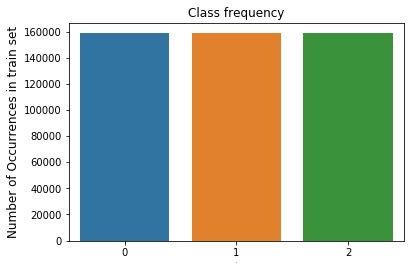

In [0]:
# just checking if dataframe is oversampled correctly and is now balanced or not
upsampled_value_counts = upsampled_train[col].value_counts()
sns.barplot(upsampled_value_counts.index, upsampled_value_counts.values)
33plt.title('Class frequency')
plt.ylabel('Number of Occurrences in train set', fontsize=12)
plt.xlabel('city', fontsize=1)
plt.show()

#Code for composing transformation of data.

 #### Resized the data to [32x32]
 #### Transformed to tensor
 #### Normalized
 ### Batch size has been taken = 512

 trainset, train loader and validate, validloader is defined here


In [0]:
apply_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
BatchSize = 512

train_ = CovidDataset(upsampled_train, False, 0, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader

validate_ = CovidDataset(validate, False, 0, transform=apply_transform)
validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)

# Defining device. (Use GPU is cuda is availabe otherwise use CPU)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Code for transfer Learning.

We are using ResNet18 pretrained model

For criterion, we are using CrossEntropyLoss, which is standard loss function for multi class classification task

For optimizer, we are using Stochastic Gradient Descent optimizer with learning rate = 0.001 and momentum = 0.9

For scheduler, we are decaying learning rate by a factor of 0.1 every 7 epochs

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decrease learning rate to 10% after every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Runnung the train model

In [0]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=3)

In [0]:
lr = 0.001
num_epochs=25
        

In [0]:
train

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
3795,Train_reshape/CheXpert-v1.0__train__patient252...,Source-3,1,2,1,0
95674,Train_reshape/CheXpert-v1.0__train__patient354...,Source-3,3,2,1,0
35673,Train_reshape/CheXpert-v1.0__train__patient029...,Source-3,1,2,1,0
55566,Train_reshape/CheXpert-v1.0__train__patient044...,Source-3,2,0,0,0
138097,Train_reshape/CheXpert-v1.0__train__patient206...,Source-3,4,2,1,0
...,...,...,...,...,...,...
33860,Train_reshape/CheXpert-v1.0__train__patient102...,Source-3,1,2,1,0
28735,Train_reshape/CheXpert-v1.0__train__patient336...,Source-3,1,2,1,0
63220,Train_reshape/CheXpert-v1.0__train__patient290...,Source-3,2,2,1,0
26389,Train_reshape/CheXpert-v1.0__train__patient495...,Source-3,1,2,1,0


#Function to get final dataset and dataloader and finally train the model on dataset

learning rate = 0.001

nummber of epochs =25


In [0]:
def final(train, validate, num_of_images):
    lr = 0.001
    num_epochs=25
    use_gpu = True
    
    validate = validate[:num_of_images]
    
    cols = ["Non-Pneumonia", "Other Pneumonia", "COVID-19"]
    for col in cols:
        upsampled_train = get_balanced(train, col)
        upsampled_train = upsampled_train[:num_of_images]
        
        apply_transform = transforms.Compose([
            transforms.Resize((32, 32)), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        BatchSize = 256
        print("Training df size ", upsampled_train.shape[0])
        train_ = CovidDataset(upsampled_train, False, 0, transform=apply_transform)
        trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
                                                  shuffle=True, num_workers=0) # Creating dataloader

        validate_ = CovidDataset(validate, False, 0, transform=apply_transform)
        validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)
        
        dataloaders = {
            'train': trainLoader,
            'val': validateLoader
        }

        dataset_sizes = {
            'train': len(train),
            'val': len(validate)
        }
        

        model_ft = models.resnet18(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 3)
        if use_gpu:
            model_ft = model_ft.cuda()

        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        
        model_ft = train_model(dataloaders, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)


In [0]:
final(train, validate, 3000)

Training df size  3000
{'train': 178964, 'val': 3000}
Epoch 0/24
----------
train Loss: 0.0112 Acc: 0.0118
val Loss: 1.6322 Acc: 0.0913

Epoch 1/24
----------
train Loss: 0.0004 Acc: 0.0168
val Loss: 2.6339 Acc: 0.0913

Epoch 2/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 4.1582 Acc: 0.0913

Epoch 3/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 5.8819 Acc: 0.0913

Epoch 4/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 7.3263 Acc: 0.0913

Epoch 5/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 8.4390 Acc: 0.0913

Epoch 6/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 9.3156 Acc: 0.0913

Epoch 7/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 9.8279 Acc: 0.0913

Epoch 8/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 10.2029 Acc: 0.0913

Epoch 9/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 10.4208 Acc: 0.0913

Epoch 10/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 10.5534 Acc: 0.0913

Epoch 11/24
----------
train 

## Number of data from each source folder

In [0]:
tmp["Data Source"].value_counts()

Source-4    624
Source-3    234
Source-6     31
Source-5     25
Source-1     25
Source-2     10
Name: Data Source, dtype: int64

## Testing accuracy of the trained model. Used source-4 in this case


In [0]:
test = pd.read_csv("data/dataset/Covid19action-radiology-CXR_v1.1/Test_Combined.csv")
test = test[test["Data Source"] != "Source-4"]

In [0]:
test_ = CovidDataset(test, False, 0, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(test_, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader


In [0]:
test.shape

(325, 5)

In [0]:
cols = ["Non-Pneumonia", "Other Pneumonia", "COVID-19"]
name = {
    cols[0]: 5,
    cols[1]: 3,
    cols[2]: 3
}
for col in cols:
    correct_pred = 0
    for data in testLoader:
        inputs,labels = data
        inputs, labels = inputs.cuda(),labels.cuda()
        #load model
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model_ft = models.resnet18(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        # Here the size of each output sample is set to 2.
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        model_ft.fc = nn.Linear(num_ftrs, 3)

        model_ft = model_ft.to(device)
        checkpoint = torch.load(f"./{col}_{BatchSize}_SGD_{lr}_{name[col]}")
        model_ft.load_state_dict(checkpoint['state_dict'], strict=False)
        
        # Feedforward train data batch through model
        output = model_ft(inputs) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)


    test_accuracy = correct_pred.item()/len(test)
    print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  10.76923076923077
Testing accuracy =  0.3076923076923077
Testing accuracy =  0.0


# Only a few epochs could be run due to which a very less amount of accuracy is avaiable here.

## Further traing using more images

We can incorporate codes to acquire more data and train the model with tne new data set.

# Whole dataset could not be trained due to computation capability limitation and time limitation. Due to MTP works it was not possible to fully dedicate myself to this project. This project requires much more rigorous work and I will update future works in my gitHub repositery afterwards.